#### **Model 1**
# **Machine Learning**

In [171]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [169]:
!pip install Augmentor
!pip install scikit-optimize
!pip install bayesian_optimization

In [166]:
from google.colab import files
uploaded = files.upload()

# Use the following code to uploade necessary modules
!ls

Saving QLearningModule.py to QLearningModule.py
alg_feature_methods_config.py  feature_methods_config.py  __pycache__	      run_model.py
drive			       model_selector.py	  QLearningModule.py  sample_data


In [175]:
# Import Libraries:
import logging
import random
import time
import numpy as np
import itertools
from bayes_opt.util import UtilityFunction
from skopt.space import Categorical
from skopt import BayesSearchCV
from skopt.space import Real
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.src.backend import random_bernoulli
import networkx as nx
import matplotlib.pyplot as plt

from itertools import combinations
from functools import partial
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

# Import Modules:
import EnvModule
from EnvModule import RunModel, MLModelSelector, METHODS_ACTIONS, ALGORITHM_METHODS


# Import datasets:
from sklearn import datasets

### **MLAgent Model**

In [180]:
class MLAgent:
    def __init__(self, problem_type, data, labels):
        self.problem_type = problem_type
        self.data = data
        self.labels = labels
        self.model_selector = MLModelSelector(problem_type=problem_type)
        self.algorithm = self.select_algorithm()
        self.model = self._initialize_model()
        self.feature_methods = self.select_feature_engineering_methods(self.algorithm)
        self.learning_history = {}  # Stores the history of the learning process
        self.best_combinations = {}  # Stores combinations with accuracy >= 90%

        # Initialize a logger
        self.logger = logging.getLogger(__name__)
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    def select_algorithm(self):
        # Use the MLModelSelector instance to select the algorithm.
        algorithm = self.model_selector.algorithm_selector()
        print("\n\nSelected algorithm:", algorithm, end="\n\n")
        return algorithm

    def _initialize_model(self):
        # Create a RunModel instance
        runner = RunModel(selected_algorithm=self.algorithm)
        self.model = runner.algorithm_processor()
        return self.model

    def select_feature_engineering_methods(self, algorithm):
        # Use the MLModelSelector instance to select the feature engineering methods.
        methods_dict = ALGORITHM_METHODS.get(algorithm)
        # If no methods are defined for the algorithm, raise an error.
        if not methods_dict:
            raise ValueError(f"No feature engineering methods defined for algorithm: {algorithm}")
        feature_methods = list(methods_dict.keys())
        self.feature_methods = feature_methods

        return feature_methods

    def apply_feature_engineering(self, dataTrain, dataTest, feature_methods, feature_combinations):
        """
        Apply the list of feature engineering methods to the data.
        :param data: The dataset to process.
        :param feature_methods: A list of feature engineering methods to apply.
        :param random_combinations: A list of selected feature engineering methods from random combinations.
        :return: The processed dataset.
        """
        print("shape of the input data is: ", dataTrain.shape)
        self.logger.info("Starting feature engineering process...")
        processed_data_trainset = []  # To avoid changing the original data
        processed_data_testset = []

        # Import the correct configuration
        print(f"Random combinations ({len(feature_combinations)}) :  {feature_combinations}")
        #print(len(random_combinations))
        cc = 1
        for feature_combination in feature_combinations:
            print(f"========================== Random combination {cc}:{feature_combination} ==========================")
            cc += 1
            data2processTest = dataTest.copy()
            data2processTrain = dataTrain.copy()
            for method in feature_methods:
                #print("method: ", method)
                print("Shape after feature engineering - Train:", data2processTrain.shape, "Test:", data2processTest.shape)
                # Check if the method is in the list of random combinations
                if method in feature_combination:
                    self.logger.info(f"Applying feature engineering for method: {method}")
                    method_func = METHODS_ACTIONS.get(method)
                    if method_func:
                        # Apply the function. This assumes that your method functions are designed
                        # to process the data and return the transformed data.
                        try:
                            data2test = method_func(data2processTest)
                            data2train = method_func(data2processTrain)
                            print("Shape of the data now is: ", data2train.shape)

                            # Check for feature consistency
                            if data2train.shape[1] != data2test.shape[1]:
                                raise ValueError(f"Inconsistent feature count: train {data2train.shape[1]} vs test {data2test.shape[1]}")

                            # Update the data to process
                            data2processTest = data2test.copy()
                            data2processTrain = data2train.copy()
                        except Exception as e:
                            self.logger.error(f"Method {method} failed: {e}")

                    else:
                        self.logger.error(f"Method {method} not recognized or not implemented.")

            processed_data_testset.append(data2processTest)
            processed_data_trainset.append(data2processTrain)

        print("=================================================================================================================================")
        for i, proc_data in enumerate(processed_data_trainset):
            print(f"Data processed after applying combination number {i+1}, shape is {proc_data.shape}")

        self.logger.info("Feature engineering completed.")

        return processed_data_trainset, processed_data_testset

    # Evaluate the model using cross validation
    def evaluate_model_cross_val(self, model, data, labels, num_folds=5):
        # Ensure that the data and labels are in the correct format
        if data.ndim == 1:
            data = data.reshape(-1, 1)

        scores = cross_val_score(model, data, labels, cv=num_folds)
        return np.mean(scores)

    def update_learning_history(self, combination, reward):
        """
        Update the learning history with the combination and reward.
        """
        combination_key = tuple(combination)
        if combination_key in self.learning_history:
            old_reward = self.learning_history[combination_key]
            self.learning_history[combination_key] = (old_reward + reward) / 2
        else:
            self.learning_history[combination_key] = reward

    def run(self, epochs=10):
        # Split the data into training and testing sets
        dataTrain, dataTest, labelsTrain, labelsTest = train_test_split(self.data, self.labels, test_size=0.2, random_state=42)

        model_num = 0
        for epoch in range(epochs):
            # Use get_informed_combinations to select feature combinations
            if epoch == 0:
                # In the first epoch, use random combinations to explore
                feature_combinations = self.get_feature_combination()
            else:
                # In subsequent epochs, use informed combinations based on learning history
                feature_combinations = self.get_informed_combinations(self.algorithm)

            processed_data_trainset, processed_data_testset = self.apply_feature_engineering(dataTrain, dataTest, self.feature_methods, feature_combinations)

            for combination, (processed_data_train, processed_data_test) in enumerate(zip(processed_data_trainset, processed_data_testset)):
                accuracy = self.evaluate_model_cross_val(self.model, processed_data_train, labelsTrain, num_folds=5) * 100

                # Print the results
                model_num += 1
                print(f"Epoch {epoch+1}, Model # {model_num}, accuracy = {accuracy:.4f}, Combination {feature_combinations[combination]}")

                # Update the learning history
                self.update_learning_history(feature_combinations[combination], accuracy)

                if accuracy >= 90.0:
                    combination_key = tuple(map(tuple, feature_combinations[combination]))  # Convert the combination to a tuple
                    self.best_combinations[combination_key] = accuracy
                    # Update best feature methods count
                    for method in feature_combinations[combination]:
                        key = (self.algorithm, method)
                        bestFEMethods[key] = bestFEMethods.get(key, 0) + 1

        return self.get_best_combination()

    def get_feature_combination(self):
        # Set seed for reproducibility
        random.seed(42)
        # Get the list of feature engineering methods for the selected algorithm.
        methods = self.feature_methods
        # Uncomment the code below to generate all possible combinations with a maximum of 3 methods
        all_combinations = []
        for r in range(1, min(4, len(methods) + 2)):  # r is the size of the combinations
            all_combinations.extend(combinations(methods, r))

        # Ensure that all_combinations is a list of lists
        all_combinations = [list(comb) for comb in all_combinations]

        print(f"Total combination {len(all_combinations)}")
        min_number_of_random_combination = 10
        # Select random combinations.
        random_combinations = all_combinations
        #random_combinations = random.sample(all_combinations, min(min_number_of_random_combination, len(all_combinations)))
        # Set as instance variable
        self.random_combinations = random_combinations

        return random_combinations

    def get_informed_combinations(self, algorithm):
        # Set random seed
        random.seed(42)
        # Get the list of feature engineering methods for the selected algorithm.
        epsilon = 0.1  # Exploration rate
        if random.random() < epsilon or not self.learning_history:
            # If exploring or if there's no learning history, get random combinations
            return self.random_combinations
        else:
            # Exploit the best combinations from the learning history
            best_combinations = sorted(self.learning_history.items(), key=lambda x: x[1], reverse=True)
            # Select the top 3 combinations based on performance
            informed_combinations = [comb[0] for comb in best_combinations[:3]]
            self.informed_combinations = informed_combinations

            return informed_combinations

    def get_best_combination(self):
        if not self.best_combinations:
            print("No combinations achieved the desired accuracy.")
            return None
        return max(self.best_combinations, key=self.best_combinations.get)

    def print_top_model_combinations(self, top_n=10):
        print("Best Tob Combinations 10")
        top_combinations = sorted(self.best_combinations.items(), key=lambda item: item[1], reverse=True)[:top_n]
        for i, (combination, accuracy) in enumerate(top_combinations, 1):
            # Concatenate the characters in each method name
            formatted_methods = []
            for method_tuple in combination:
                method_name = ''.join(method_tuple)
                formatted_methods.append(method_name)

            formatted_method_names = ', '.join(formatted_methods)
            print(f"Combination {i}: {formatted_method_names} - Accuracy: {accuracy:.2f}%")


# Load the dataset
iris = datasets.load_iris()
data, labels = iris.data, iris.target

# Define global variables
bestFEMethods = {}
min_number_of_random_combination = 10
PROBLEM = "Prediction(multi-outcome)"

# Assuming you have already created and run the agent
agent = MLAgent(problem_type=PROBLEM, data=data, labels=labels)
agent.run(epochs=10)

def print_best_feature_methods(bestFEMethods):
    print("Best feature methods (Based on Importance):")
    for key, value in sorted(bestFEMethods.items(), key=lambda x: x[1], reverse=True):
        print(f"{key}: {value}")



Selected algorithm: decision_tree

Total combination 175
shape of the input data is:  (120, 4)
Random combinations (175) :  [['variance_threshold_selector'], ['principal_component_analysis'], ['kernel_pca'], ['independent_component_analysis'], ['non_negative_matrix_factorization'], ['singular_value_decomposition'], ['feature_agglomeration'], ['StandardScaler'], ['Binning'], ['PolynomialFeature-Interaction'], ['variance_threshold_selector', 'principal_component_analysis'], ['variance_threshold_selector', 'kernel_pca'], ['variance_threshold_selector', 'independent_component_analysis'], ['variance_threshold_selector', 'non_negative_matrix_factorization'], ['variance_threshold_selector', 'singular_value_decomposition'], ['variance_threshold_selector', 'feature_agglomeration'], ['variance_threshold_selector', 'StandardScaler'], ['variance_threshold_selector', 'Binning'], ['variance_threshold_selector', 'PolynomialFeature-Interaction'], ['principal_component_analysis', 'kernel_pca'], ['pri

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


 Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
========================== Random combination 18:['variance_threshold_selector', 'Binning'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engine

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maxim

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 31:['kernel_pca', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape af

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whi

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 40:['independent_component_analysis', 'PolynomialFeature-Interaction'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (12

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maxim

Shape of the data now is:  (120, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 65:['variance_threshold_selector', 'kernel_pca', 'non_negative_matrix_factorization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 4)
Shape after feature engineering - Train: (120, 4) Test: (

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Startin

Negative values found. Shifting data to be non-negative.
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 72:['variance_threshold_selector', 'independent_component_analysis', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature e

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


(120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 93:['principal_component_analysis', 'kernel_pca', 'non_negative_matrix_factorization'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Negative values found. Shifting data to be non-negative.
Negative values found. Shifting data to be non-n

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whi

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 100:['principal_component_analysis', 'independent_component_analysis', 'singular_value_decomposition'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Startin

Negative values found. Shifting data to be non-negative.
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 127:['kernel_pca', 'non_negative_matrix_factorization', 'feature_agglomeration'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Negative values found. Shifting data to b

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 133:['kernel_pca', 'singular_value_decomposition', 'Binning'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after featu

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWa

Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 147:['independent_component_analysis', 'singular_value_decomposition', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whi

Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
Shape after feature engineering - Train: (120, 2) Test: (30, 2)
========================== Random combination 157:['non_negative_matrix_factorization', 'singular_value_decomposition', 'StandardScaler'] ==========================
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape after feature engineering - Train: (120, 4) Test: (30, 4)
Shape of the data now is:  (120, 2)
Shape after feature engineering - Tra

In [185]:
agent.print_top_model_combinations(top_n=10)
print("=================================================================================================================================")
print_best_feature_methods(bestFEMethods)

Best Tob Combinations 10
Combination 1: non_negative_matrix_factorization, singular_value_decomposition, Binning - Accuracy: 98.33%
Combination 2: singular_value_decomposition, feature_agglomeration - Accuracy: 97.50%
Combination 3: variance_threshold_selector, singular_value_decomposition, feature_agglomeration - Accuracy: 97.50%
Combination 4: singular_value_decomposition, feature_agglomeration, StandardScaler - Accuracy: 97.50%
Combination 5: singular_value_decomposition, Binning - Accuracy: 96.67%
Combination 6: variance_threshold_selector, singular_value_decomposition, Binning - Accuracy: 96.67%
Combination 7: singular_value_decomposition, feature_agglomeration, Binning - Accuracy: 96.67%
Combination 8: singular_value_decomposition, StandardScaler, Binning - Accuracy: 96.67%
Combination 9: singular_value_decomposition, StandardScaler, PolynomialFeature-Interaction - Accuracy: 96.67%
Combination 10: singular_value_decomposition, Binning, PolynomialFeature-Interaction - Accuracy: 96

## **MLAgent Visiualization**

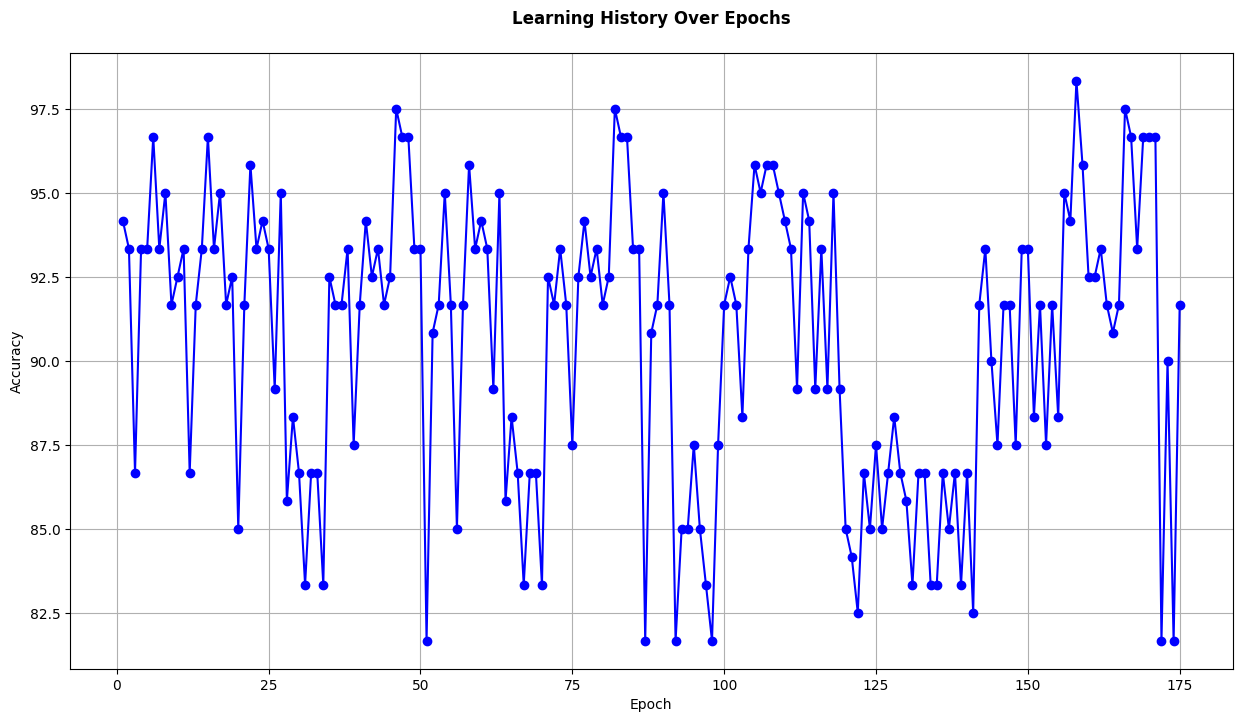




----------------------------------------------------------------------------------------------------------


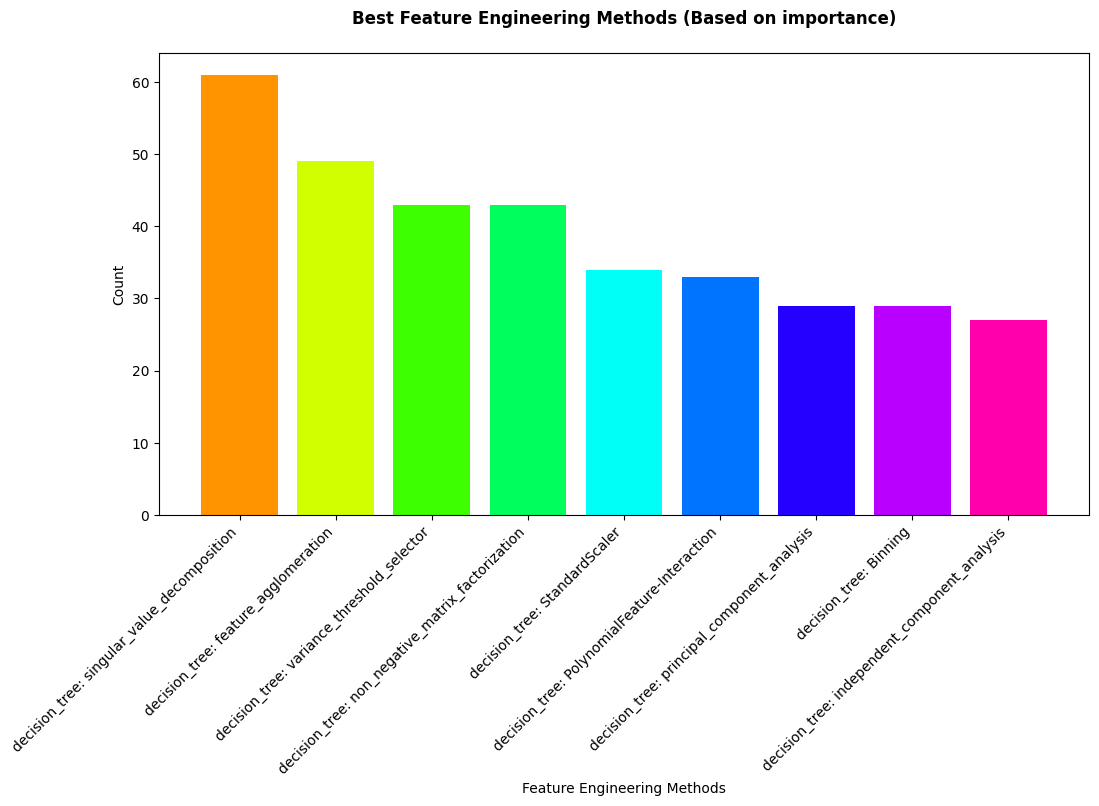




----------------------------------------------------------------------------------------------------------


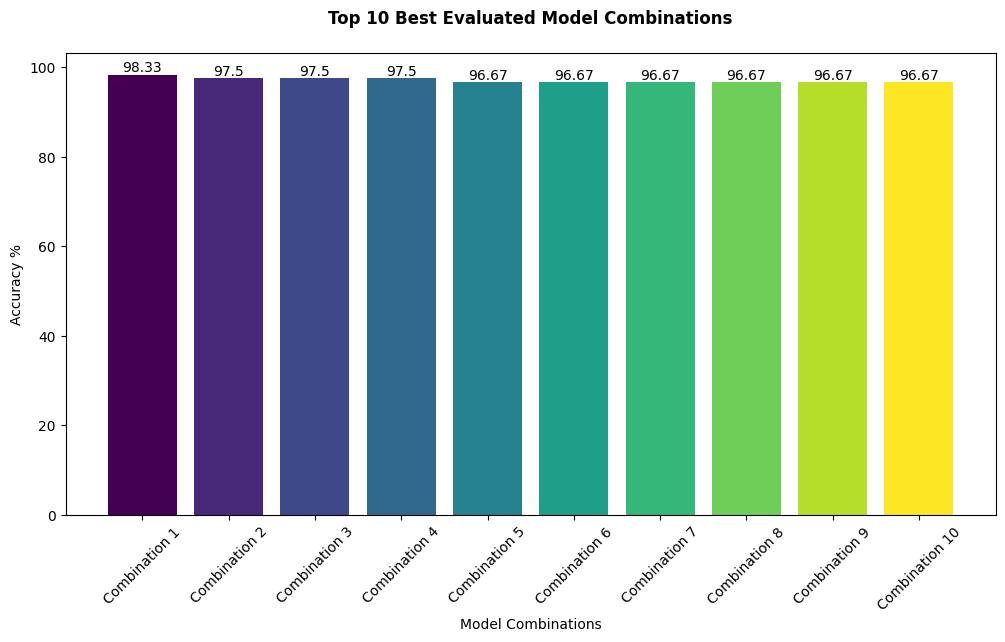

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

# Learning History Over Epochs
def plot_learning_history(agent):
    epochs = range(1, len(agent.learning_history) + 1)
    accuracies = list(agent.learning_history.values())
    plt.figure(figsize=(15, 8))
    plt.plot(epochs, accuracies, marker='o', linestyle='-', color='b')
    plt.title('Learning History Over Epochs\n', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
plot_learning_history(agent)
print("\n\n")
print("----------------------------------------------------------------------------------------------------------")

# Best Feature Engineering Methods
def plot_best_feature_methods(bestFEMethods):
    methods = [f'{algorithm}: {method}' for algorithm, method in bestFEMethods.keys()]
    counts = list(bestFEMethods.values())
    sorted_indices = sorted(range(len(counts)), key=lambda i: counts[i], reverse=True)
    sorted_methods = [methods[i] for i in sorted_indices]
    sorted_counts = [counts[i] for i in sorted_indices]
    colors = sns.color_palette("hsv", len(sorted_methods))
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(sorted_methods)), sorted_counts, color=colors, tick_label=sorted_methods)
    plt.xlabel('Feature Engineering Methods')
    plt.ylabel('Count')
    plt.title('Best Feature Engineering Methods (Based on importance)\n', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.show()
plot_best_feature_methods(bestFEMethods)
print("\n\n")
print("----------------------------------------------------------------------------------------------------------")

# Top 10 Best Evaluated Model Combinations
def plot_combination_accuracies(agent):
    sorted_combinations = sorted(agent.best_combinations.items(), key=lambda x: x[1], reverse=True)[:10]
    combinations = [f'Combination {i+1}' for i in range(len(sorted_combinations))]
    accuracies = [acc for _, acc in sorted_combinations]
    colors = plt.cm.viridis(np.linspace(0, 1, len(combinations)))
    plt.figure(figsize=(12, 6))
    bars = plt.bar(combinations, accuracies, color=colors)
    plt.xlabel('Model Combinations')
    plt.ylabel('Accuracy %')
    plt.title('Top 10 Best Evaluated Model Combinations\n', fontweight='bold')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 2), ha='center', va='bottom')
    plt.xticks(rotation=45)
    plt.show()
plot_combination_accuracies(agent)

In [184]:
print("Learning history per epoch:")
num_epochs = 10
for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}:")
  for combo, reward in agent.learning_history.items():
    print(f"- {combo}: {reward}")

Learning history per epoch:
Epoch 1:
- ('variance_threshold_selector',): 94.16666666666667
- ('principal_component_analysis',): 93.33333333333333
- ('kernel_pca',): 86.66666666666666
- ('independent_component_analysis',): 93.33333333333333
- ('non_negative_matrix_factorization',): 93.33333333333333
- ('singular_value_decomposition',): 96.66666666666666
- ('feature_agglomeration',): 93.33333333333333
- ('StandardScaler',): 95.0
- ('Binning',): 91.66666666666666
- ('PolynomialFeature-Interaction',): 92.5
- ('variance_threshold_selector', 'principal_component_analysis'): 93.33333333333333
- ('variance_threshold_selector', 'kernel_pca'): 86.66666666666666
- ('variance_threshold_selector', 'independent_component_analysis'): 91.66666666666666
- ('variance_threshold_selector', 'non_negative_matrix_factorization'): 93.33333333333333
- ('variance_threshold_selector', 'singular_value_decomposition'): 96.66666666666666
- ('variance_threshold_selector', 'feature_agglomeration'): 93.33333333333333
